In [1]:
import numpy as np 
import os
import mne
import pandas as pd
from itertools import compress
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import re
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# import the data here (Sai)


C:/Users/takoy/fnirs-github/neurotech_fnir_mind/data/rest15.snirf
Loading C:\Users\takoy\fnirs-github\neurotech_fnir_mind\data\rest15.snirf


C:\Users\takoy\AppData\Local\Temp\ipykernel_22444\3905839829.py:10: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw_intensity = mne.io.read_raw_snirf(file_path, verbose=True)


Reading 0 ... 22949  =      0.000 ...   458.980 secs...


C:\Users\takoy\AppData\Local\Temp\ipykernel_22444\3905839829.py:19: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 8251 samples (165.020 s)

Creating RawArray with float64 data, n_channels=1, n_times=22950


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


    Range : 0 ... 22949 =      0.000 ...   458.980 secs
Ready.
(73, 22950)
45 events found on stim channel stim
Event IDs: [1 2 3]
Not setting metadata
45 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 1001 original time points ...
    Rejecting  epoch based on HBO : ['S15_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo', 'S13_D14 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo', 'S13_D14 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo', 'S13_D14 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo', 'S13_D13 hbo', 'S13_D14 hbo', 'S14_D15 hbo', 'S15_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoch based on HBO : ['S2_D1 hbo', 'S13_D13 hbo', 'S13_D14 hbo', 'S14_D15 hbo', 'S15_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoc

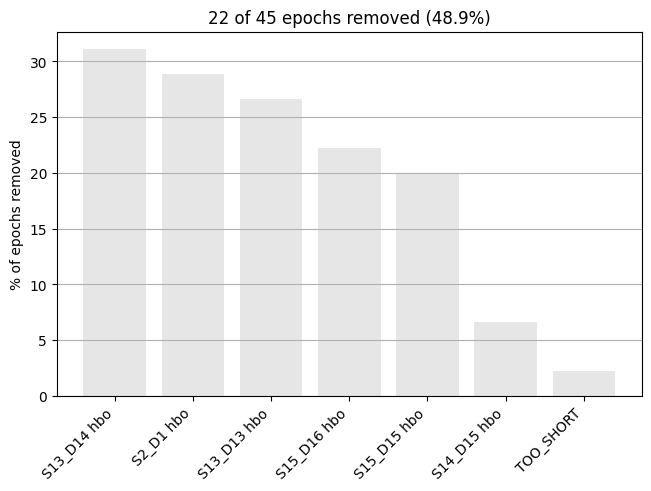

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


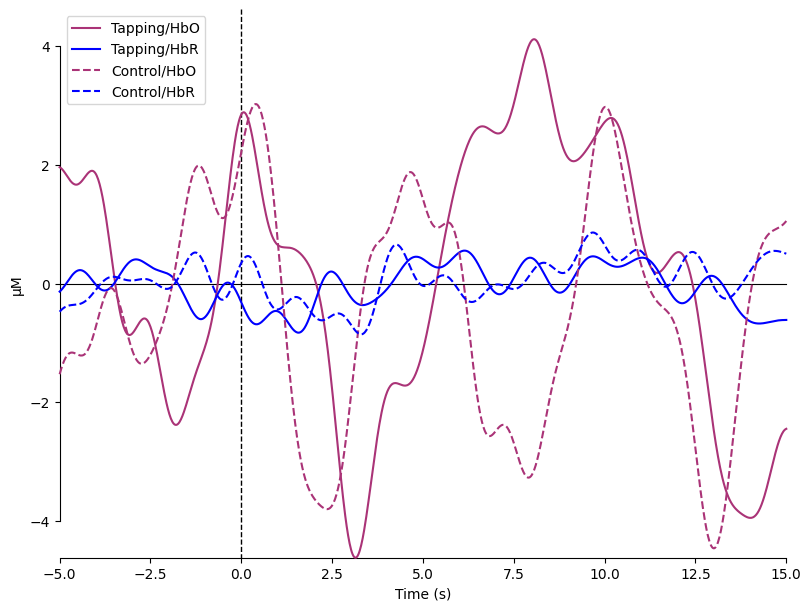

C:/Users/takoy/fnirs-github/neurotech_fnir_mind/data/rest17.snirf
Loading C:\Users\takoy\fnirs-github\neurotech_fnir_mind\data\rest17.snirf
Reading 0 ... 18049  =      0.000 ...   360.980 secs...


C:\Users\takoy\AppData\Local\Temp\ipykernel_22444\3905839829.py:10: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw_intensity = mne.io.read_raw_snirf(file_path, verbose=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 8251 samples (165.020 s)

Creating RawArray with float64 data, n_channels=1, n_times=18050
    Range : 0 ... 18049 =      0.000 ...   360.980 secs
Ready.
(73, 18050)
36 events found on stim channel stim
Event IDs: [1 2 3]
Not setting metadata
36 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1001 original time points ...
 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


    Rejecting  epoch based on HBO : ['S11_D11 hbo', 'S15_D15 hbo']
    Rejecting  epoch based on HBO : ['S11_D11 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo', 'S12_D12 hbo', 'S15_D15 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo', 'S12_D12 hbo', 'S13_D14 hbo', 'S15_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo', 'S12_D12 hbo', 'S13_D13 hbo', 'S13_D14 hbo', 'S15_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo', 'S11_D11 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo', 'S13_D13 hbo', 'S13_D14 hbo']
    Rejecting  epoch based on HBO : ['S9_D11 hbo', 'S13_D13 hbo', 'S13_D14 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S2_D1 hbo', 'S9_D11 hbo', 'S11_D11 hbo', 'S12_D12 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S2_D1 hbo', 'S4_D1 hbo', 'S9_D11 hbo', 'S11_D11 hbo', 'S12_D11 hbo', 'S12_D

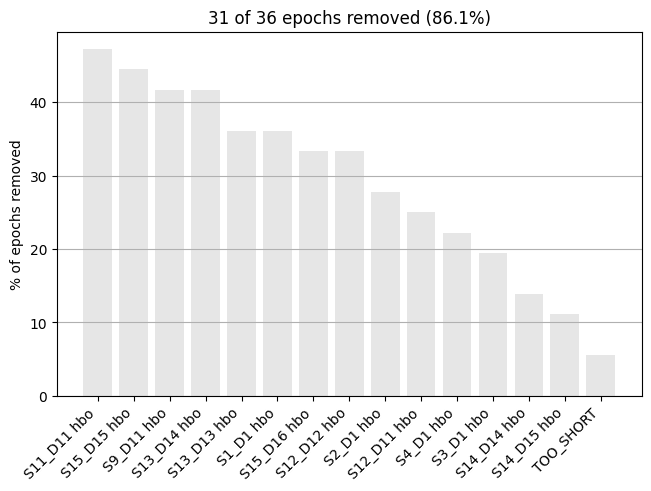

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


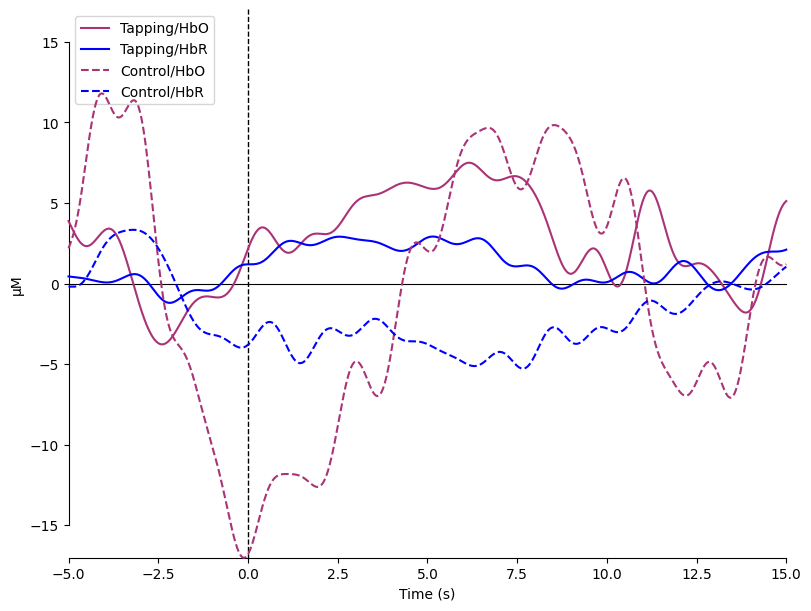

C:/Users/takoy/fnirs-github/neurotech_fnir_mind/data/rest18.snirf
Loading C:\Users\takoy\fnirs-github\neurotech_fnir_mind\data\rest18.snirf
Reading 0 ... 18649  =      0.000 ...   372.980 secs...


C:\Users\takoy\AppData\Local\Temp\ipykernel_22444\3905839829.py:10: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw_intensity = mne.io.read_raw_snirf(file_path, verbose=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 8251 samples (165.020 s)

Creating RawArray with float64 data, n_channels=1, n_times=18650
    Range : 0 ... 18649 =      0.000 ...   372.980 secs
Ready.
(73, 18650)
36 events found on stim channel stim
Event IDs: [1 2 3]
Not setting metadata
36 matching events found


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 1001 original time points ...
    Rejecting  epoch based on HBO : ['S6_D5 hbo']
    Rejecting  epoch based on HBO : ['S6_D5 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S6_D5 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S6_D5 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S6_D5 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S6_D5 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S4_D4 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S6_D5 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S6_D5 hbo', 'S13_D13 hbo']
    Rejecting  epoch based on HBO : ['S4_D2 hbo', 'S4_D4 hbo', 'S5_D5 hbo', 'S6_D5 hbo', 'S13_D13 hbo', 'S13_D14 hbo', 'S14_D14 hbo', 'S15_D16 hbo']
    Rejecting  epoch base

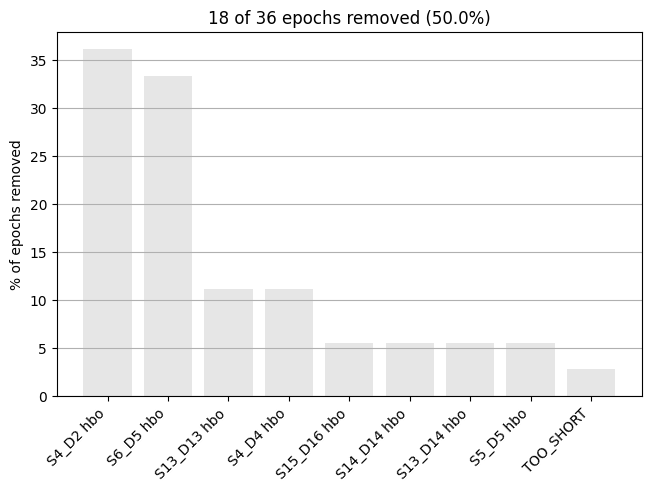

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


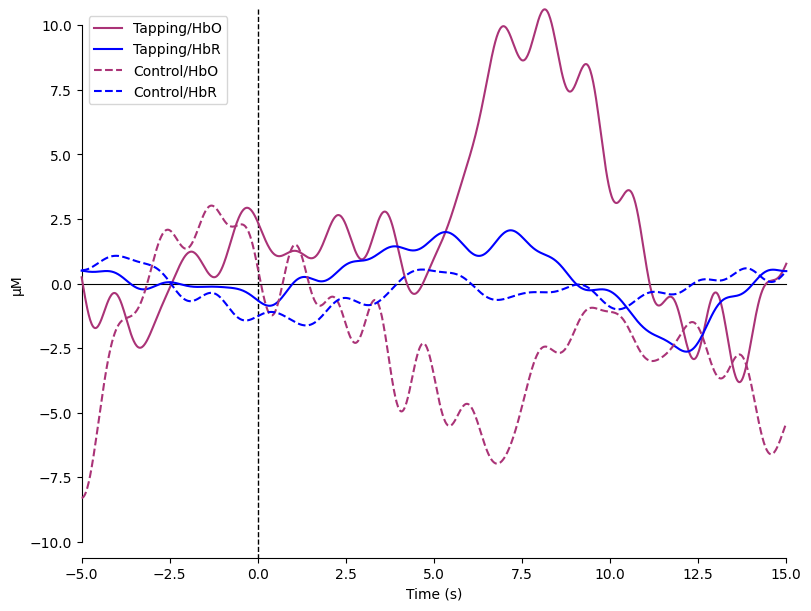

C:/Users/takoy/fnirs-github/neurotech_fnir_mind/data/rest20.snirf
Loading C:\Users\takoy\fnirs-github\neurotech_fnir_mind\data\rest20.snirf
Reading 0 ... 11199  =      0.000 ...   223.980 secs...


C:\Users\takoy\AppData\Local\Temp\ipykernel_22444\3905839829.py:10: RuntimeWarning: The data only contains 2D location information for the optode positions. It is highly recommended that data is used which contains 3D location information for the optode positions. With only 2D locations it can not be guaranteed that MNE functions will behave correctly and produce accurate results. If it is not possible to include 3D positions in your data, please consider using the set_montage() function.
  raw_intensity = mne.io.read_raw_snirf(file_path, verbose=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 8251 samples (165.020 s)

Creating RawArray with float64 data, n_channels=1, n_times=11200
    Range : 0 ... 11199 =      0.000 ...   223.980 secs
Ready.
(73, 11200)
21 events found on stim channel stim
Event IDs: [1 2 3]
Not setting metadata
21 matching events found
Setting baseline interval to [-5.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 1001 original time points ...
 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s


    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S5_D3 hbo', 'S5_D5 hbo', 'S6_D3 hbo', 'S6_D4 hbo', 'S6_D5 hbo', 'S6_D6 hbo', 'S8_D7 hbo', 'S8_D9 hbo', 'S11_D11 hbo', 'S13_D14 hbo', 'S14_D14 hbo', 'S14_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S5_D3 hbo', 'S5_D5 hbo', 'S6_D3 hbo', 'S6_D4 hbo', 'S6_D5 hbo', 'S6_D6 hbo', 'S8_D7 hbo', 'S8_D9 hbo', 'S11_D11 hbo', 'S13_D13 hbo', 'S13_D14 hbo', 'S14_D14 hbo', 'S14_D15 hbo', 'S15_D16 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S5_D3 hbo', 'S5_D5 hbo', 'S6_D3 hbo', 'S6_D4 hbo', 'S6_D5 hbo', 'S6_D6 hbo', 'S8_D7 hbo', 'S8_D9 hbo', 'S13_D13 hbo', 'S13_D14 hbo', 'S14_D14 hbo']
    Rejecting  epoch based on HBO : ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D3 hbo', 'S4_D4 hbo', 'S5_D3 hbo', 'S5_D5 hbo', 'S6_D3 hbo', 'S6_D4 hbo', 'S6_D5 hbo', 'S6_D

C:\Users\takoy\AppData\Local\Temp\ipykernel_22444\3905839829.py:56: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(


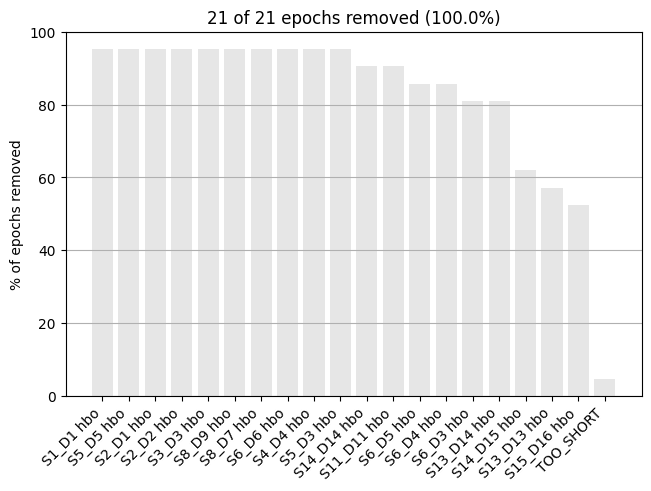

RuntimeError: epochs.average() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.

In [8]:

#convert the data file from NIRs to CSV

# preprocess the data values (worked on by Thomas and Ian)
data_path = r'C:/Users/takoy/fnirs-github/neurotech_fnir_mind/data/'
for file in os.listdir(data_path):
    file_path = os.path.join(data_path, file)
    if not file.endswith(".snirf"):
        continue
    print(file_path)
    raw_intensity = mne.io.read_raw_snirf(file_path, verbose=True)
    raw_intensity.load_data()

    picks = mne.pick_types(raw_intensity.info, meg=False, fnirs=True)
    dists = mne.preprocessing.nirs.source_detector_distances(
        raw_intensity.info, picks = picks
    )
    raw_intensity.pick(picks[dists > 0.01])
    
    raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)

    sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)

    raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))

    raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw_od, ppf=0.1)

    raw_haemo_unfiltered = raw_haemo.copy()
    raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)

    stim_ch = np.zeros((1, raw_haemo.n_times))

    #insert events manually here?
    sfreq = raw_haemo.info['sfreq']  # Get sampling rate
    event_interval = int(10 * sfreq)  # One event every 10 seconds
    num_events = (raw_haemo.n_times // event_interval)  # Total possible events

    manual_events = np.arange(event_interval, raw_haemo.n_times, event_interval)  # Generate event times
    manual_codes = np.tile([1, 2, 3], len(manual_events) // 3)  # Repeat conditions

    for e, c in zip(manual_events, manual_codes):
        stim_ch[0, e] = c

    info = mne.create_info(['stim'], raw_haemo.info['sfreq'], ch_types='stim')
    stim_raw = mne.io.RawArray(stim_ch, info)
    raw_haemo.add_channels([stim_raw], force_update_info=True)

    #debugging
    print(raw_haemo.get_data().shape)

    events = mne.find_events(raw_haemo, stim_channel='stim', min_duration=0.01)
    event_dict = {"Control": 1, "Tapping/Left": 2, "Tapping/Right": 3}

    reject_criteria = dict(hbo=80e-6)
    tmin, tmax = -5, 15

    epochs = mne.Epochs(
        raw_haemo,
        events,
        event_id=event_dict,
        tmin=tmin,
        tmax=tmax,
        reject=reject_criteria,
        reject_by_annotation=True,
        proj=True,
        baseline=(None, 0),
        preload=True,
        detrend=None,
        verbose=True,
    )
    print("drop log here ##############################")
    epochs.plot_drop_log()

    if (len(epochs) == 0):
        print("no epochs found...")
        continue
    evoked_dict = {
        "Tapping/HbO": epochs["Tapping/Left"].average(picks="hbo"),
        "Tapping/HbR": epochs["Tapping/Left"].average(picks="hbr"),
        "Control/HbO": epochs["Control"].average(picks="hbo"),
        "Control/HbR": epochs["Control"].average(picks="hbr"),
    }

    # Rename channels until the encoding of frequency in ch_name is fixed
    for condition in evoked_dict:
        evoked_dict[condition].rename_channels(lambda x: x[:-4])

    color_dict = dict(HbO="#AA3377", HbR="b")
    styles_dict = dict(Control=dict(linestyle="dashed"))

    if evoked_dict:
        mne.viz.plot_compare_evokeds(
            evoked_dict, combine="mean", ci=0.95, colors=color_dict, styles=styles_dict
        )
    else:
        print("No valid epochs found for plotting.")



In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = None

#X_train, X_test, y_train, y_test = train_test_split(, , test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions:
y_pred = model.predict(X_test)

#Get data from fNIRs (Elan)

# calculating the mean values.
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()
